# NOte:
This notebook was used to combine the redrock fitting to fastspec to see if i can obtain a source redshift by first creating a lensed quasar using the fastspec elg fit. Super imposing it with the quasar spectrum. Then 

In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

In [3]:
# Release directory path

specprod = 'fuji'    # Internal name for the EDR
specprod_dir = '/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/'

In [4]:
tiles_table = Table.read(f'{specprod_dir}/tiles-{specprod}.fits',)

In [5]:
zpix_cat = Table.read(f'{specprod_dir}/zcatalog/zall-pix-{specprod}.fits', hdu="ZCATALOG")

In [6]:
# Selecting a random object which has multiple spectra in DESI
sel = (zpix_cat['ZCAT_NSPEC'] >= 1)
targets = zpix_cat[sel]['TARGETID']

In [7]:
np.where(targets == 39627098284888595)

(array([395900]),)

In [8]:
ii = 395900
targetid = targets[ii]

In [9]:
# Selecting the redshift catalogs rows for the particular targetid
rows = zpix_cat['TARGETID'] == targetid
zcat_sel = zpix_cat[rows]

In [10]:
healpix_dir = f'{specprod_dir}/healpix'

# Defining healpix, survey, and program variables for this target

survey_col = zcat_sel['SURVEY'].astype(str)
program_col = zcat_sel['PROGRAM'].astype(str)
hpx_col = zcat_sel['HEALPIX']

# Selecting the primary spectra - 
is_primary = zcat_sel['ZCAT_PRIMARY']

# Information needed to access the spectra 
survey = survey_col[is_primary][0]
program = program_col[is_primary][0]
hpx = hpx_col[is_primary][0]    ## This is same for all the rows, given its the same TARGET. But, just to be consistent.

# Let us explore the target directory
# Note that the target directory is different for the different spectra.
# We first explore the primary spectra and look at the other spectra later.
tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'

In [11]:
# Filename - 
coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'

In [12]:
# Using desispec to read the spectra

coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
coadd_tgts = coadd_obj.target_ids().data

INFO:spectra.py:291:read_spectra: iotime 1.064 sec to read coadd-sv1-bright-34725.fits at 2024-07-05T10:01:14.578061


In [13]:
row = (coadd_tgts == targetid)
coadd_spec = coadd_obj[row]

In [14]:
# Combined Spectra - 

spec_combined = coaddition.coadd_cameras(coadd_spec)

# Load in Fastspec File for one object

In [6]:
import fitsio
import healpy
from astropy.io import fits
from astropy.table import Table, join
import os

In [7]:
datadir = '/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/v3.0/catalogs'
fast = Table(fitsio.read(os.path.join(datadir, 'fastspec-fuji.fits'), 'FASTSPEC'))
meta = Table(fitsio.read(os.path.join(datadir, 'fastspec-fuji.fits'), 'METADATA'))

In [17]:
fast

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,COEFF [192],RCHI2,RCHI2_CONT,RCHI2_PHOT,SNR_B,SNR_R,SNR_Z,SMOOTHCORR_B,SMOOTHCORR_R,SMOOTHCORR_Z,VDISP,VDISP_IVAR,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000,DN4000_OBS,DN4000_IVAR,DN4000_MODEL,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_SPECMODEL_G,FLUX_SYNTH_SPECMODEL_R,FLUX_SYNTH_SPECMODEL_Z,FLUX_SYNTH_PHOTMODEL_G,FLUX_SYNTH_PHOTMODEL_R,FLUX_SYNTH_PHOTMODEL_Z,FLUX_SYNTH_PHOTMODEL_W1,FLUX_SYNTH_PHOTMODEL_W2,FLUX_SYNTH_PHOTMODEL_W3,FLUX_SYNTH_PHOTMODEL_W4,ABSMAG10_DECAM_G,ABSMAG10_IVAR_DECAM_G,KCORR10_DECAM_G,ABSMAG10_DECAM_R,ABSMAG10_IVAR_DECAM_R,KCORR10_DECAM_R,ABSMAG10_DECAM_Z,ABSMAG10_IVAR_DECAM_Z,KCORR10_DECAM_Z,ABSMAG00_U,ABSMAG00_IVAR_U,KCORR00_U,ABSMAG00_B,ABSMAG00_IVAR_B,KCORR00_B,ABSMAG00_V,ABSMAG00_IVAR_V,KCORR00_V,ABSMAG01_SDSS_U,ABSMAG01_IVAR_SDSS_U,KCORR01_SDSS_U,ABSMAG01_SDSS_G,ABSMAG01_IVAR_SDSS_G,KCORR01_SDSS_G,ABSMAG01_SDSS_R,ABSMAG01_IVAR_SDSS_R,KCORR01_SDSS_R,ABSMAG01_SDSS_I,ABSMAG01_IVAR_SDSS_I,KCORR01_SDSS_I,ABSMAG01_SDSS_Z,ABSMAG01_IVAR_SDSS_Z,KCORR01_SDSS_Z,ABSMAG01_W1,ABSMAG01_IVAR_W1,KCORR01_W1,LOGLNU_1500,LOGLNU_2800,LOGL_1450,LOGL_1700,LOGL_3000,LOGL_5100,FLYA_1215_CONT,FOII_3727_CONT,FHBETA_CONT,FOIII_5007_CONT,FHALPHA_CONT,RCHI2_LINE,DELTA_LINECHI2,DELTA_LINENDOF,APERCORR,APERCORR_G,APERCORR_R,APERCORR_Z,NARROW_Z,NARROW_ZRMS,BROAD_Z,BROAD_ZRMS,UV_Z,UV_ZRMS,NARROW_SIGMA,NARROW_SIGMARMS,BROAD_SIGMA,BROAD_SIGMARMS,UV_SIGMA,UV_SIGMARMS,MGII_DOUBLET_RATIO,OII_DOUBLET_RATIO,SII_DOUBLET_RATIO,LYALPHA_MODELAMP,LYALPHA_AMP,LYALPHA_AMP_IVAR,LYALPHA_FLUX,LYALPHA_FLUX_IVAR,LYALPHA_BOXFLUX,LYALPHA_BOXFLUX_IVAR,LYALPHA_VSHIFT,LYALPHA_SIGMA,LYALPHA_CONT,LYALPHA_CONT_IVAR,LYALPHA_EW,LYALPHA_EW_IVAR,LYALPHA_FLUX_LIMIT,LYALPHA_EW_LIMIT,LYALPHA_CHI2,LYALPHA_NPIX,OI_1304_MODELAMP,OI_1304_AMP,OI_1304_AMP_IVAR,OI_1304_FLUX,OI_1304_FLUX_IVAR,OI_1304_BOXFLUX,OI_1304_BOXFLUX_IVAR,OI_1304_VSHIFT,OI_1304_SIGMA,OI_1304_CONT,OI_1304_CONT_IVAR,OI_1304_EW,OI_1304_EW_IVAR,OI_1304_FLUX_LIMIT,OI_1304_EW_LIMIT,OI_1304_CHI2,OI_1304_NPIX,SILIV_1396_MODELAMP,SILIV_1396_AMP,SILIV_1396_AMP_IVAR,SILIV_1396_FLUX,SILIV_1396_FLUX_IVAR,SILIV_1396_BOXFLUX,SILIV_1396_BOXFLUX_IVAR,SILIV_1396_VSHIFT,SILIV_1396_SIGMA,SILIV_1396_CONT,SILIV_1396_CONT_IVAR,SILIV_1396_EW,SILIV_1396_EW_IVAR,SILIV_1396_FLUX_LIMIT,SILIV_1396_EW_LIMIT,SILIV_1396_CHI2,SILIV_1396_NPIX,CIV_1549_MODELAMP,CIV_1549_AMP,CIV_1549_AMP_IVAR,CIV_1549_FLUX,CIV_1549_FLUX_IVAR,CIV_1549_BOXFLUX,CIV_1549_BOXFLUX_IVAR,CIV_1549_VSHIFT,CIV_1549_SIGMA,CIV_1549_CONT,CIV_1549_CONT_IVAR,CIV_1549_EW,CIV_1549_EW_IVAR,CIV_1549_FLUX_LIMIT,CIV_1549_EW_LIMIT,CIV_1549_CHI2,CIV_1549_NPIX,HEII_1640_MODELAMP,HEII_1640_AMP,HEII_1640_AMP_IVAR,HEII_1640_FLUX,HEII_1640_FLUX_IVAR,HEII_1640_BOXFLUX,HEII_1640_BOXFLUX_IVAR,HEII_1640_VSHIFT,HEII_1640_SIGMA,HEII_1640_CONT,HEII_1640_CONT_IVAR,HEII_1640_EW,HEII_1640_EW_IVAR,HEII_1640_FLUX_LIMIT,HEII_1640_EW_LIMIT,HEII_1640_CHI2,HEII_1640_NPIX,ALIII_1857_MODELAMP,ALIII_1857_AMP,ALIII_1857_AMP_IVAR,ALIII_1857_FLUX,ALIII_1857_FLUX_IVAR,ALIII_1857_BOXFLUX,ALIII_1857_BOXFLUX_IVAR,ALIII_1857_VSHIFT,ALIII_1857_SIGMA,ALIII_1857_CONT,ALIII_1857_CONT_IVAR,ALIII_1857_EW,ALIII_1857_EW_IVAR,ALIII_1857_FLUX_LIMIT,ALIII_1857_EW_LIMIT,ALIII_1857_CHI2,ALIII_1857_NPIX,SILIII_1892_MODELAMP,SILIII_1892_AMP,SILIII_1892_AMP_IVAR,SILIII_1892_FLUX,SILIII_1892_FLUX_IVAR,SILIII_1892_BOXFLUX,SILIII_1892_BOXFLUX_IVAR,SILIII_1892_VSHIFT,SILIII_1892_SIGMA,SILIII_1892_CONT,SILIII_1892_CONT_IVAR,SILIII_1892_EW,SILIII_1892_EW_IVAR,SILIII_1892_FLUX_LIMIT,SILIII_1892_EW_LIMIT,SILIII_1892_CHI2,SILIII_1892_NPIX,CIII_1908_MODELAMP,CIII_1908_AMP,CIII_1908_AMP_IVAR,CIII_1908_FLUX,CIII_1908_FLUX_IVAR,CIII_1908_BOXFLUX,CIII_1908_BOXFLUX_IVAR,CIII_1908_VSHIFT,CIII_1908_SIGMA,CIII_1908_CONT,CIII_1908_CONT_IVAR,CIII_1908_EW,CIII_1908_EW_IVAR,CIII_1908_FLUX_LIMIT,CIII_1908_EW_LIMIT,CIII_1908_CHI2,CIII_1908_NPIX,MGII_2796_MODELAMP,MGII_2796_AMP,MGII_2796_AMP_IVAR,MGII_2796_FLUX,MGII_2796_FLUX_IVAR,MGII_2796_BOXFLUX,MGII_2796_BOXFLUX_IVAR,MGII_2796_VSHIFT,MGII_2796_SIGMA,MGII_2796_C

In [21]:
filtered_df = fast[(fast['OII_3726_FLUX'] >= 2) & (fast['Z'] > 0.03) & (fast['Z'] < 1.9)]
filtered_df

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,COEFF [192],RCHI2,RCHI2_CONT,RCHI2_PHOT,SNR_B,SNR_R,SNR_Z,SMOOTHCORR_B,SMOOTHCORR_R,SMOOTHCORR_Z,VDISP,VDISP_IVAR,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000,DN4000_OBS,DN4000_IVAR,DN4000_MODEL,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_SPECMODEL_G,FLUX_SYNTH_SPECMODEL_R,FLUX_SYNTH_SPECMODEL_Z,FLUX_SYNTH_PHOTMODEL_G,FLUX_SYNTH_PHOTMODEL_R,FLUX_SYNTH_PHOTMODEL_Z,FLUX_SYNTH_PHOTMODEL_W1,FLUX_SYNTH_PHOTMODEL_W2,FLUX_SYNTH_PHOTMODEL_W3,FLUX_SYNTH_PHOTMODEL_W4,ABSMAG10_DECAM_G,ABSMAG10_IVAR_DECAM_G,KCORR10_DECAM_G,ABSMAG10_DECAM_R,ABSMAG10_IVAR_DECAM_R,KCORR10_DECAM_R,ABSMAG10_DECAM_Z,ABSMAG10_IVAR_DECAM_Z,KCORR10_DECAM_Z,ABSMAG00_U,ABSMAG00_IVAR_U,KCORR00_U,ABSMAG00_B,ABSMAG00_IVAR_B,KCORR00_B,ABSMAG00_V,ABSMAG00_IVAR_V,KCORR00_V,ABSMAG01_SDSS_U,ABSMAG01_IVAR_SDSS_U,KCORR01_SDSS_U,ABSMAG01_SDSS_G,ABSMAG01_IVAR_SDSS_G,KCORR01_SDSS_G,ABSMAG01_SDSS_R,ABSMAG01_IVAR_SDSS_R,KCORR01_SDSS_R,ABSMAG01_SDSS_I,ABSMAG01_IVAR_SDSS_I,KCORR01_SDSS_I,ABSMAG01_SDSS_Z,ABSMAG01_IVAR_SDSS_Z,KCORR01_SDSS_Z,ABSMAG01_W1,ABSMAG01_IVAR_W1,KCORR01_W1,LOGLNU_1500,LOGLNU_2800,LOGL_1450,LOGL_1700,LOGL_3000,LOGL_5100,FLYA_1215_CONT,FOII_3727_CONT,FHBETA_CONT,FOIII_5007_CONT,FHALPHA_CONT,RCHI2_LINE,DELTA_LINECHI2,DELTA_LINENDOF,APERCORR,APERCORR_G,APERCORR_R,APERCORR_Z,NARROW_Z,NARROW_ZRMS,BROAD_Z,BROAD_ZRMS,UV_Z,UV_ZRMS,NARROW_SIGMA,NARROW_SIGMARMS,BROAD_SIGMA,BROAD_SIGMARMS,UV_SIGMA,UV_SIGMARMS,MGII_DOUBLET_RATIO,OII_DOUBLET_RATIO,SII_DOUBLET_RATIO,LYALPHA_MODELAMP,LYALPHA_AMP,LYALPHA_AMP_IVAR,LYALPHA_FLUX,LYALPHA_FLUX_IVAR,LYALPHA_BOXFLUX,LYALPHA_BOXFLUX_IVAR,LYALPHA_VSHIFT,LYALPHA_SIGMA,LYALPHA_CONT,LYALPHA_CONT_IVAR,LYALPHA_EW,LYALPHA_EW_IVAR,LYALPHA_FLUX_LIMIT,LYALPHA_EW_LIMIT,LYALPHA_CHI2,LYALPHA_NPIX,OI_1304_MODELAMP,OI_1304_AMP,OI_1304_AMP_IVAR,OI_1304_FLUX,OI_1304_FLUX_IVAR,OI_1304_BOXFLUX,OI_1304_BOXFLUX_IVAR,OI_1304_VSHIFT,OI_1304_SIGMA,OI_1304_CONT,OI_1304_CONT_IVAR,OI_1304_EW,OI_1304_EW_IVAR,OI_1304_FLUX_LIMIT,OI_1304_EW_LIMIT,OI_1304_CHI2,OI_1304_NPIX,SILIV_1396_MODELAMP,SILIV_1396_AMP,SILIV_1396_AMP_IVAR,SILIV_1396_FLUX,SILIV_1396_FLUX_IVAR,SILIV_1396_BOXFLUX,SILIV_1396_BOXFLUX_IVAR,SILIV_1396_VSHIFT,SILIV_1396_SIGMA,SILIV_1396_CONT,SILIV_1396_CONT_IVAR,SILIV_1396_EW,SILIV_1396_EW_IVAR,SILIV_1396_FLUX_LIMIT,SILIV_1396_EW_LIMIT,SILIV_1396_CHI2,SILIV_1396_NPIX,CIV_1549_MODELAMP,CIV_1549_AMP,CIV_1549_AMP_IVAR,CIV_1549_FLUX,CIV_1549_FLUX_IVAR,CIV_1549_BOXFLUX,CIV_1549_BOXFLUX_IVAR,CIV_1549_VSHIFT,CIV_1549_SIGMA,CIV_1549_CONT,CIV_1549_CONT_IVAR,CIV_1549_EW,CIV_1549_EW_IVAR,CIV_1549_FLUX_LIMIT,CIV_1549_EW_LIMIT,CIV_1549_CHI2,CIV_1549_NPIX,HEII_1640_MODELAMP,HEII_1640_AMP,HEII_1640_AMP_IVAR,HEII_1640_FLUX,HEII_1640_FLUX_IVAR,HEII_1640_BOXFLUX,HEII_1640_BOXFLUX_IVAR,HEII_1640_VSHIFT,HEII_1640_SIGMA,HEII_1640_CONT,HEII_1640_CONT_IVAR,HEII_1640_EW,HEII_1640_EW_IVAR,HEII_1640_FLUX_LIMIT,HEII_1640_EW_LIMIT,HEII_1640_CHI2,HEII_1640_NPIX,ALIII_1857_MODELAMP,ALIII_1857_AMP,ALIII_1857_AMP_IVAR,ALIII_1857_FLUX,ALIII_1857_FLUX_IVAR,ALIII_1857_BOXFLUX,ALIII_1857_BOXFLUX_IVAR,ALIII_1857_VSHIFT,ALIII_1857_SIGMA,ALIII_1857_CONT,ALIII_1857_CONT_IVAR,ALIII_1857_EW,ALIII_1857_EW_IVAR,ALIII_1857_FLUX_LIMIT,ALIII_1857_EW_LIMIT,ALIII_1857_CHI2,ALIII_1857_NPIX,SILIII_1892_MODELAMP,SILIII_1892_AMP,SILIII_1892_AMP_IVAR,SILIII_1892_FLUX,SILIII_1892_FLUX_IVAR,SILIII_1892_BOXFLUX,SILIII_1892_BOXFLUX_IVAR,SILIII_1892_VSHIFT,SILIII_1892_SIGMA,SILIII_1892_CONT,SILIII_1892_CONT_IVAR,SILIII_1892_EW,SILIII_1892_EW_IVAR,SILIII_1892_FLUX_LIMIT,SILIII_1892_EW_LIMIT,SILIII_1892_CHI2,SILIII_1892_NPIX,CIII_1908_MODELAMP,CIII_1908_AMP,CIII_1908_AMP_IVAR,CIII_1908_FLUX,CIII_1908_FLUX_IVAR,CIII_1908_BOXFLUX,CIII_1908_BOXFLUX_IVAR,CIII_1908_VSHIFT,CIII_1908_SIGMA,CIII_1908_CONT,CIII_1908_CONT_IVAR,CIII_1908_EW,CIII_1908_EW_IVAR,CIII_1908_FLUX_LIMIT,CIII_1908_EW_LIMIT,CIII_1908_CHI2,CIII_1908_NPIX,MGII_2796_MODELAMP,MGII_2796_AMP,MGII_2796_AMP_IVAR,MGII_2796_FLUX,MGII_2796_FLUX_IVAR,MGII_2796_BOXFLUX,MGII_2796_BOXFLUX_IVAR,MGII_2796_VSHIFT,MGII_2796_SIGMA,MGII_2796_C

(array([ 6122.,  8581., 11549., 14221., 13313., 15753., 20625., 15751.,
        16485., 17867., 17272., 16508., 17408., 17053., 19541., 15338.,
        15063., 12589., 13445., 11476., 10273.,  9151.,  8167.,  7664.,
         7580.,  6601.,  5813.,  5123.,  4619.,  4469.,  4031.,  3834.,
         4275.,  3190.,  2914.,  3032.,  3193.,  3370.,  3403.,  3185.,
         3940.,  3902.,  4363.,  5695.,  6095.,  7052.,  7438.,  8868.,
         9001.,  9367.,  9364., 10340., 10018.,  9679., 10352., 10493.,
        10305., 10458., 10454., 10142.,  9270.,  8928.,  9357.,  8539.,
         8073.,  7831.,  7443.,  7009.,  7107.,  7042.,  7144.,  7040.,
         6985.,  6775.,  6936.,  6326.,  5978.,  5778.,  5988.,  6174.,
         5944.,  5687.,  5617.,  5578.,  4999.,  5125.,  5049.,  4693.,
         4708.,  4844.,  4907.,  4711.,  4038.,  3833.,  3558.,  3641.,
         3617.,  3423.,  3283.,  2902.]),
 array([0.03000701, 0.04602542, 0.06204383, 0.07806225, 0.09408066,
        0.11009907, 0.1261

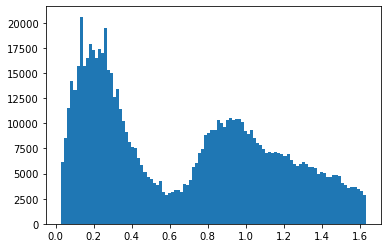

In [23]:
plt.hist(filtered_df['Z'], bins = 100)

In [8]:
np.where(meta['TARGETID'] == 39627752164299778)

(array([99808]),)

In [9]:
fast[99808]

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,COEFF [192],RCHI2,RCHI2_CONT,RCHI2_PHOT,SNR_B,SNR_R,SNR_Z,SMOOTHCORR_B,SMOOTHCORR_R,SMOOTHCORR_Z,VDISP,VDISP_IVAR,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000,DN4000_OBS,DN4000_IVAR,DN4000_MODEL,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_SPECMODEL_G,FLUX_SYNTH_SPECMODEL_R,FLUX_SYNTH_SPECMODEL_Z,FLUX_SYNTH_PHOTMODEL_G,FLUX_SYNTH_PHOTMODEL_R,FLUX_SYNTH_PHOTMODEL_Z,FLUX_SYNTH_PHOTMODEL_W1,FLUX_SYNTH_PHOTMODEL_W2,FLUX_SYNTH_PHOTMODEL_W3,FLUX_SYNTH_PHOTMODEL_W4,ABSMAG10_DECAM_G,ABSMAG10_IVAR_DECAM_G,KCORR10_DECAM_G,ABSMAG10_DECAM_R,ABSMAG10_IVAR_DECAM_R,KCORR10_DECAM_R,ABSMAG10_DECAM_Z,ABSMAG10_IVAR_DECAM_Z,KCORR10_DECAM_Z,ABSMAG00_U,ABSMAG00_IVAR_U,KCORR00_U,ABSMAG00_B,ABSMAG00_IVAR_B,KCORR00_B,ABSMAG00_V,ABSMAG00_IVAR_V,KCORR00_V,ABSMAG01_SDSS_U,ABSMAG01_IVAR_SDSS_U,KCORR01_SDSS_U,ABSMAG01_SDSS_G,ABSMAG01_IVAR_SDSS_G,KCORR01_SDSS_G,ABSMAG01_SDSS_R,ABSMAG01_IVAR_SDSS_R,KCORR01_SDSS_R,ABSMAG01_SDSS_I,ABSMAG01_IVAR_SDSS_I,KCORR01_SDSS_I,ABSMAG01_SDSS_Z,ABSMAG01_IVAR_SDSS_Z,KCORR01_SDSS_Z,ABSMAG01_W1,ABSMAG01_IVAR_W1,KCORR01_W1,LOGLNU_1500,LOGLNU_2800,LOGL_1450,LOGL_1700,LOGL_3000,LOGL_5100,FLYA_1215_CONT,FOII_3727_CONT,FHBETA_CONT,FOIII_5007_CONT,FHALPHA_CONT,RCHI2_LINE,DELTA_LINECHI2,DELTA_LINENDOF,APERCORR,APERCORR_G,APERCORR_R,APERCORR_Z,NARROW_Z,NARROW_ZRMS,BROAD_Z,BROAD_ZRMS,UV_Z,UV_ZRMS,NARROW_SIGMA,NARROW_SIGMARMS,BROAD_SIGMA,BROAD_SIGMARMS,UV_SIGMA,UV_SIGMARMS,MGII_DOUBLET_RATIO,OII_DOUBLET_RATIO,SII_DOUBLET_RATIO,LYALPHA_MODELAMP,LYALPHA_AMP,LYALPHA_AMP_IVAR,LYALPHA_FLUX,LYALPHA_FLUX_IVAR,LYALPHA_BOXFLUX,LYALPHA_BOXFLUX_IVAR,LYALPHA_VSHIFT,LYALPHA_SIGMA,LYALPHA_CONT,LYALPHA_CONT_IVAR,LYALPHA_EW,LYALPHA_EW_IVAR,LYALPHA_FLUX_LIMIT,LYALPHA_EW_LIMIT,LYALPHA_CHI2,LYALPHA_NPIX,OI_1304_MODELAMP,OI_1304_AMP,OI_1304_AMP_IVAR,OI_1304_FLUX,OI_1304_FLUX_IVAR,OI_1304_BOXFLUX,OI_1304_BOXFLUX_IVAR,OI_1304_VSHIFT,OI_1304_SIGMA,OI_1304_CONT,OI_1304_CONT_IVAR,OI_1304_EW,OI_1304_EW_IVAR,OI_1304_FLUX_LIMIT,OI_1304_EW_LIMIT,OI_1304_CHI2,OI_1304_NPIX,SILIV_1396_MODELAMP,SILIV_1396_AMP,SILIV_1396_AMP_IVAR,SILIV_1396_FLUX,SILIV_1396_FLUX_IVAR,SILIV_1396_BOXFLUX,SILIV_1396_BOXFLUX_IVAR,SILIV_1396_VSHIFT,SILIV_1396_SIGMA,SILIV_1396_CONT,SILIV_1396_CONT_IVAR,SILIV_1396_EW,SILIV_1396_EW_IVAR,SILIV_1396_FLUX_LIMIT,SILIV_1396_EW_LIMIT,SILIV_1396_CHI2,SILIV_1396_NPIX,CIV_1549_MODELAMP,CIV_1549_AMP,CIV_1549_AMP_IVAR,CIV_1549_FLUX,CIV_1549_FLUX_IVAR,CIV_1549_BOXFLUX,CIV_1549_BOXFLUX_IVAR,CIV_1549_VSHIFT,CIV_1549_SIGMA,CIV_1549_CONT,CIV_1549_CONT_IVAR,CIV_1549_EW,CIV_1549_EW_IVAR,CIV_1549_FLUX_LIMIT,CIV_1549_EW_LIMIT,CIV_1549_CHI2,CIV_1549_NPIX,HEII_1640_MODELAMP,HEII_1640_AMP,HEII_1640_AMP_IVAR,HEII_1640_FLUX,HEII_1640_FLUX_IVAR,HEII_1640_BOXFLUX,HEII_1640_BOXFLUX_IVAR,HEII_1640_VSHIFT,HEII_1640_SIGMA,HEII_1640_CONT,HEII_1640_CONT_IVAR,HEII_1640_EW,HEII_1640_EW_IVAR,HEII_1640_FLUX_LIMIT,HEII_1640_EW_LIMIT,HEII_1640_CHI2,HEII_1640_NPIX,ALIII_1857_MODELAMP,ALIII_1857_AMP,ALIII_1857_AMP_IVAR,ALIII_1857_FLUX,ALIII_1857_FLUX_IVAR,ALIII_1857_BOXFLUX,ALIII_1857_BOXFLUX_IVAR,ALIII_1857_VSHIFT,ALIII_1857_SIGMA,ALIII_1857_CONT,ALIII_1857_CONT_IVAR,ALIII_1857_EW,ALIII_1857_EW_IVAR,ALIII_1857_FLUX_LIMIT,ALIII_1857_EW_LIMIT,ALIII_1857_CHI2,ALIII_1857_NPIX,SILIII_1892_MODELAMP,SILIII_1892_AMP,SILIII_1892_AMP_IVAR,SILIII_1892_FLUX,SILIII_1892_FLUX_IVAR,SILIII_1892_BOXFLUX,SILIII_1892_BOXFLUX_IVAR,SILIII_1892_VSHIFT,SILIII_1892_SIGMA,SILIII_1892_CONT,SILIII_1892_CONT_IVAR,SILIII_1892_EW,SILIII_1892_EW_IVAR,SILIII_1892_FLUX_LIMIT,SILIII_1892_EW_LIMIT,SILIII_1892_CHI2,SILIII_1892_NPIX,CIII_1908_MODELAMP,CIII_1908_AMP,CIII_1908_AMP_IVAR,CIII_1908_FLUX,CIII_1908_FLUX_IVAR,CIII_1908_BOXFLUX,CIII_1908_BOXFLUX_IVAR,CIII_1908_VSHIFT,CIII_1908_SIGMA,CIII_1908_CONT,CIII_1908_CONT_IVAR,CIII_1908_EW,CIII_1908_EW_IVAR,CIII_1908_FLUX_LIMIT,CIII_1908_EW_LIMIT,CIII_1908_CHI2,CIII_1908_NPIX,MGII_2796_MODELAMP,MGII_2796_AMP,MGII_2796_AMP_IVAR,MGII_2796_FLUX,MGII_2796_FLUX_IVAR,MGII_2796_BOXFLUX,MGII_2796_BOXFLUX_IVAR,MGII_2796_VSHIFT,MGII_2796_SIGMA,MGII_2796_C

In [10]:
import pandas as pd
r = meta
jj = 99808
r['TARGETID'][jj]
ra = r['RA'][jj]
dec = r['DEC'][jj]
target_id = r['TARGETID'][jj]
program = r['PROGRAM'][jj]
survey = r['SURVEY'][jj]
healpix = str(healpy.ang2pix(64, ra, dec, lonlat=True, nest=True))
hp_group = healpix[:-2]
hp_path = '/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/v3.0/healpix/' + survey + '/' + program + '/' + hp_group + '/' + str(healpix)
hp_path = hp_path + '/fastspec-' + survey + '-'+program + '-' + healpix + '.fits.gz'

hp_spectra = fits.open(hp_path)
hp_ind = np.where(hp_spectra[2].data['TARGETID'] == target_id)[0][0]

continuum = hp_spectra[3].data[hp_ind,0,:]
smooth_continuum = hp_spectra[3].data[hp_ind,1,:]
emission = hp_spectra[3].data[hp_ind,2,:]
wavelength = np.arange(3600, 9824+.8, .8)
table_elg = pd.DataFrame({'Wavelength': wavelength, 'Flux': (continuum+emission)}, columns=['Wavelength', 'Flux'])


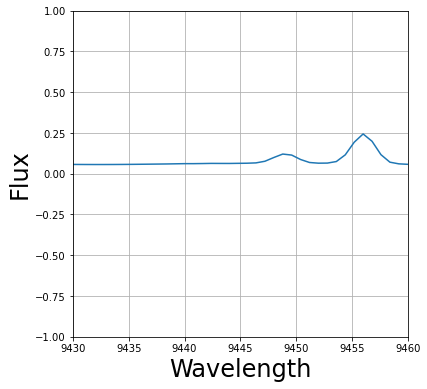

In [19]:
plt.figure(figsize = (6,6))
plt.plot(wavelength, table_elg['Flux'])
#plt.plot(spec_combined.wave['brz'], 5*spec_combined.flux['brz'][0])
plt.xlim(9430, 9460)
plt.ylim(-1, 1)
plt.ylabel('Flux', fontsize = 24)
plt.xlabel('Wavelength', fontsize = 24)
plt.grid()

In [16]:
import os
import numpy as np
from redrock.external import boss
from redrock.zfind import zfind

from redrock.targets import Spectrum, Target, DistTargetsCopy
from redrock.templates import load_dist_templates

# LENSED GLAXY TEST

In [25]:
# Visualize the lensed galaxy
from astropy.convolution import convolve 

Text(0.5, 1.0, 'Lens Example')

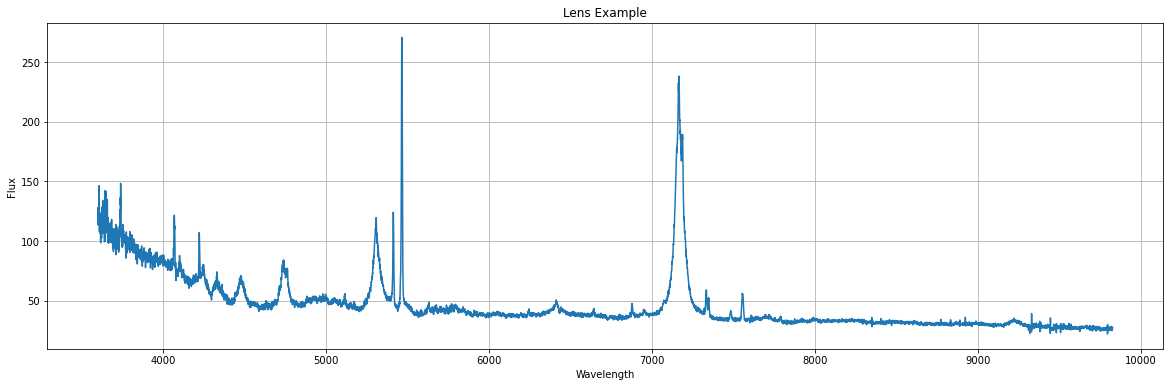

In [91]:
plt.figure(figsize = (20,6))
plt.grid()
plt.plot(wavelength, 3*table_elg['Flux'] + spec_combined.flux['brz'][0])
plt.ylabel('Flux')
plt.xlabel('Wavelength')
plt.title('Lens Example')

In [92]:
con = 3*table_elg['Flux'] + spec_combined.flux['brz'][0]

In [93]:
len(con)

7781

In [1]:
dense_array = spec_combined.R['brz'][0]

NameError: name 'spec_combined' is not defined

In [95]:
spectrum = Spectrum(spec_combined.wave['brz'], con, 
                    spec_combined.ivar['brz'][0], dense_array)

In [96]:
# Simulate a target with a single spectrum
target_id = 39628449278591796
target = Target(target_id, [spectrum])

# Simulate distributed targets with a single target
# Note: You might need to initialize MPI before using this code
#       or modify the DistTargetsCopy class accordingly if MPI is not used.

dtargets = DistTargetsCopy([target])

In [97]:
dwave = dtargets.wavegrids()
dtemplates = load_dist_templates(dwave)
templates = dict()
for dt in dtemplates:
    templates[dt.template.full_type] = dt.template

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Read and broadcast of 10 templates: 0.1 seconds
Rebinning templates: 11.2 seconds


In [98]:
zscan, zfit = zfind(dtargets, dtemplates)

Computing redshifts
  Scanning redshifts for template GALAXY
    Progress:   0 %
    Progress:  10 %
    Finished in: 1.6 seconds
  Scanning redshifts for template QSO
    Progress:   0 %
    Progress:  10 %
    Finished in: 1.0 seconds
  Scanning redshifts for template STAR:::A
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.2 seconds
  Scanning redshifts for template STAR:::B
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.2 seconds
  Scanning redshifts for template STAR:::CV
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.2 seconds
  Scanning redshifts for template STAR:::F
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.3 seconds
  Scanning redshifts for template STAR:::G
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.4 seconds
  Scanning redshifts for template STAR:::K
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.3 seconds
  Scanning redshifts for template STAR:::M
    Progress:   0 %
    Progress:  10 %
    Fin

In [99]:
zfit

targetid,z,zerr,zwarn,chi2,zz [15],zzchi2 [15],coeff [10],npixels,spectype,subtype,ncoeff,znum,deltachi2
int64,float64,float64,int64,float64,float64,float64,float64,int64,str6,str20,int64,int64,float64
39628449278591796,0.09107505637733354,3.119528509609908e-06,0,209678.90644824505,0.0894048366089133 .. 0.09191617412051234,408339.05155052803 .. 269118.5298443724,0.07870711898133476 .. 0.0,7774,QSO,,4,0,962945.4724789858
39628449278591796,0.09097493622355546,2.4416966405366766e-06,0,798919.9046902657,0.08999142349732625 .. 0.09149834300269899,903984.6325586548 .. 846365.9861506583,24533.134803806297 .. -2708.936159737984,7774,GALAXY,,10,1,373704.4742369652
39628449278591796,1.560893161639289,3.421159038118871e-05,0,1172624.3789272308,1.5567560899496278 .. 1.5626500214440817,1179438.7523890054 .. 1174127.6964740818,0.013334511537523203 .. 0.0,7774,QSO,,4,2,104332.41614627838
39628449278591796,0.43453351118206507,5.393484776944788e-06,0,1276956.7950735092,0.43391391993250705 .. 0.43589631429671094,1285328.0245201243 .. 1295918.254599194,15622.35423912602 .. -1361.7815422367214,7774,GALAXY,,10,3,8451.475552916527
39628449278591796,0.18286872009639527,1.558402146892506e-05,0,1285408.2706264257,0.18174311506408158 .. 0.18337688181860878,1288945.620748578 .. 1286125.9413820955,31471.24338542575 .. -702.1877658520265,7774,GALAXY,,10,4,156262.41236355645
39628449278591796,0.0007942858130214189,3.6722455240340377e-06,0,1441670.6829899822,0.0007600000000000072 .. 0.0008400000000000074,1441777.1215548702 .. 1441780.1778696491,11198.834861360481 .. 0.0,7774,STAR,F,5,5,94001.72722110408
39628449278591796,0.0007871358325424228,3.17538537117538e-06,0,1466091.0942998421,0.0007600000000000072 .. 0.0008400000000000074,1466167.0079019978 .. 1466256.5736450762,11150.487311607403 .. 0.0,7774,STAR,G,5,6,69581.31591124414
39628449278591796,0.0019499988354702163,4.103309083489595e-06,0,1504423.4803865787,0.0019200000000000102 .. 0.0020000000000000104,1504472.6960284014 .. 1504505.8649318544,10495.292427088625 .. 0.0,7774,STAR,K,5,7,9083.740303491242
39628449278591796,1.2828814312138335,2.4133944541784746e-05,0,1535672.4102110863,1.2813362378069337 .. 1.2865952609708184,1537227.07302353 .. 1539358.5247407923,0.011504764921064982 .. 0.0,7774,QSO,,4,8,225599.8869607905


In [100]:
tid = target_id
t_qso = templates['QSO']

## several minima are stored in the zfit table
minumum_number = 0

## select the target id and minumum number
w = (zfit[:]['targetid']==tid) & (zfit[:]['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z']

## compute the best fit:
fit = t_qso.eval(coeff[:4],spec_combined.wave['brz'],zbest)

## remultiply by (1+z)
fit *= (1+zbest)

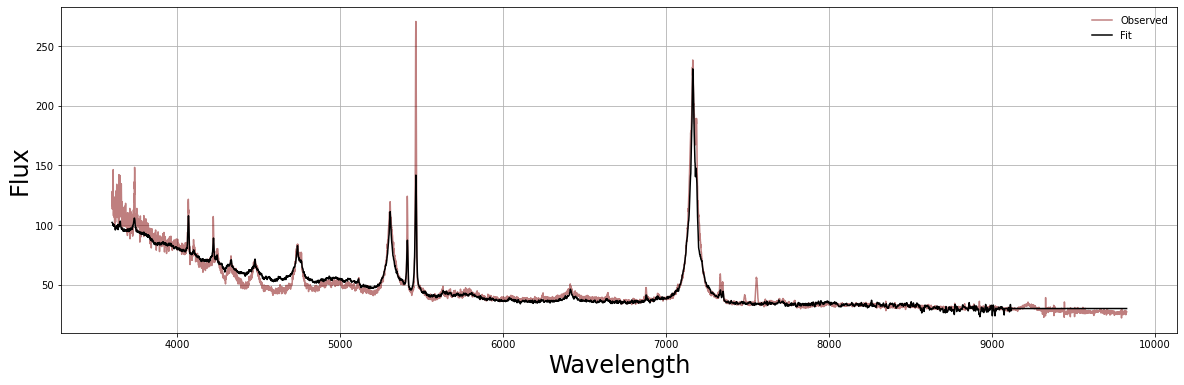

In [101]:
plt.figure(figsize = (20, 6))
wave=spec_combined.wave['brz']
flux_new = con
plt.plot(wave,flux_new, 'maroon', label = 'Observed', alpha = .5)
plt.plot(wave,fit, 'black', label = 'Fit')
plt.xlabel("Wavelength", fontsize=24)
plt.ylabel("Flux", fontsize=24)
plt.grid(True)
plt.legend(loc=0, frameon=False)

In [102]:
# Residual Subtraction

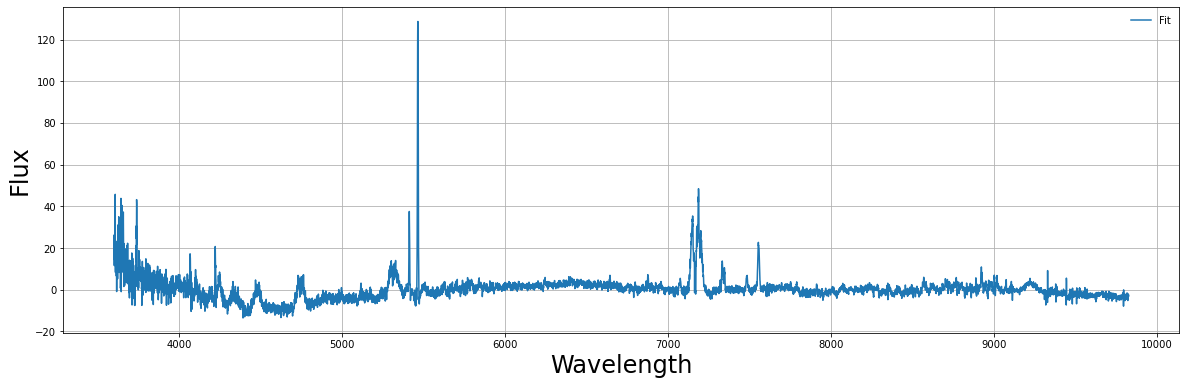

In [103]:
plt.figure(figsize = (20, 6))
wave=spec_combined.wave['brz']
flux_sub = spec_combined.flux['brz'][0]
#plt.plot(wave,flux, 'black', label = 'Observed')
plt.plot(wave,-fit + flux_new, label = 'Fit')
plt.xlabel("Wavelength", fontsize=24)
plt.ylabel("Flux", fontsize=24)
plt.grid(True)
plt.legend(loc=0, frameon=False)

In [72]:
y = - fit + flux_new

In [73]:
zfit['z'][0]

0.09107546720394177

In [74]:
from scipy.interpolate import interp1d

def mask_QSO(wave, flux, ivar, l_width, redshift):
    '''
    Hard-coded mask for QSO broad emissions. The line width parameter allows to stretch the masks.
    
    Parameters:
        wave: Wavelength array
        flux: Flux array
        ivar: Inverse variance array
        l_width: Typical line width of QSO broad emissions
        redshift: Redshift value of the QSO
    Returns:
        flux_masked: Flux array with masked regions interpolated and large errors applied
        ivar_masked: Inverse variance array with interpolated values and large errors
    '''

    # Define the lines and their relative widths, adjusted for redshift
    lines = np.array([1215.668, 1240, 1400.0, 1549.0, 1640.0, 1909.0, 2326.0, 
                      2382.765, 2427, 2600.173, 2798.0, 3426.0, 3727, 3869, 
                      4101, 4340, 4861, 4959, 5007, 6562.81, 6816, 6734]) * (1 + redshift)
    widths = np.array([2.5, 0.5, 1.5, 2, 1, 1, 1, 1, 1, 1, 2.5, 0.5, 1.5, 
                       10.5, 10.5, 10.5, 10, 1, 2, 3, 1, 1])

    # Define masking ranges based on the line widths
    start_stop_table = np.array([lines - widths * l_width, lines + widths * l_width]).T

    # Interpolate over the masked regions and assign large errors
    flux_masked = flux.copy()
    ivar_masked = ivar.copy()
    for start, stop in start_stop_table:
        mask = (wave >= start) & (wave <= stop)
        if np.any(mask):
            # Interpolate over masked regions
            interp_func = interp1d(wave[~mask], flux[~mask], kind='linear', fill_value='extrapolate')
            flux_masked[mask] = interp_func(wave[mask])
            # Assign large errors to masked regions in the ivar array
            ivar_masked[mask] = 1.0 / 1e20  # Adjust the value as needed
    
    return flux_masked, ivar_masked



flux_masked, ivar_masked = mask_QSO(spec_combined.wave['brz'], y, spec_combined.ivar['brz'][0], 10, zfit['z'][0])

/tmp/ipykernel_1715462/3168342861.py:30: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(wave, 1/np.sqrt(ivar_masked), label='Inverse Variance', color='green')


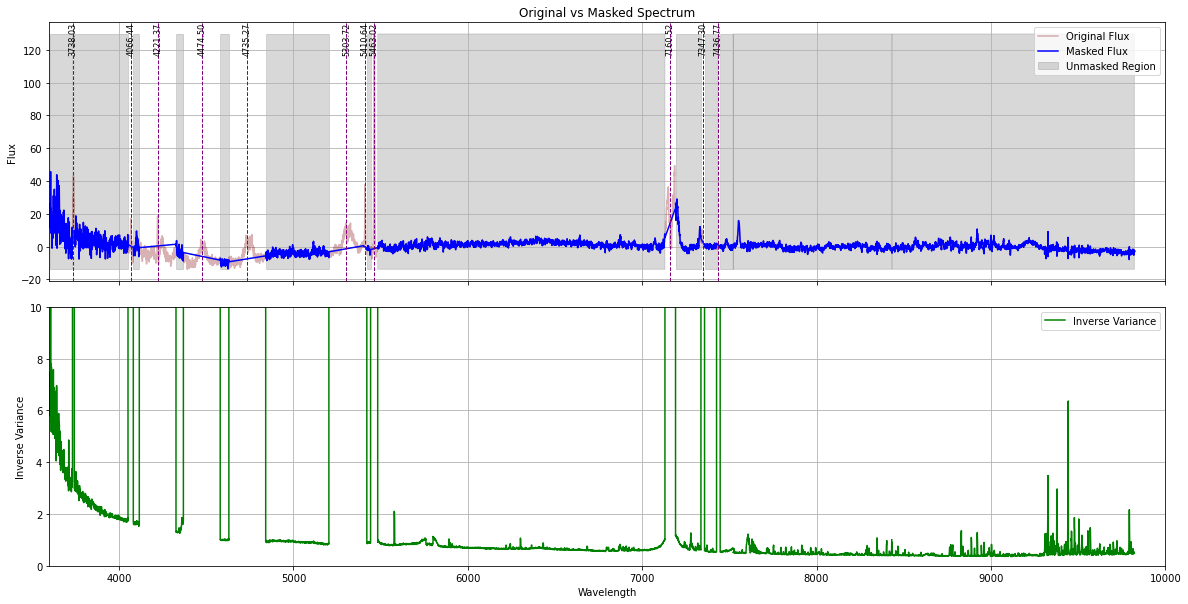

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Main plot
ax1.plot(wave, y, label='Original Flux', color='maroon', alpha=0.3)
ax1.plot(wave, flux_masked, label='Masked Flux', color='Blue')
ax1.fill_between(wave, y.min(), y.max(), where=ivar_masked > 1.0/1e20, color='grey', alpha=0.3, label='Unmasked Region')

lines = np.array([1215.668, 1240, 1400.0, 1549.0, 1640.0, 1909.0, 2326.0,
                  2382.765, 2427, 2600.173, 2798.0, 3426.0, 3727, 3869,
                  4101, 4340, 4861, 4959, 5007, 6562.81, 6816, 6734]) * (1 + 0.09107560617522027)
widths = np.array([2.5, 0.5, 1.5, 2, 1, 1, 1, 1, 1, 1, 2.5, 0.5, 1.5,
                   10.5, 10.5, 10.5, 10, 1, 2, 3, 1, 1])

# Define masking ranges based on the line positions and widths
for line, width in zip(lines, widths):
    start = line - width * 10
    stop = line + width * 10
    if start >= 3600 and stop <= 10000:
        ax1.axvspan(start, stop, color='white', alpha=0.1)
        ax1.axvline(x=line, color='purple', linestyle='--', linewidth=1)  # Add vertical lines for each line position
        ax1.text(line, ax1.get_ylim()[1], f'{line:.2f}', fontsize=8, rotation=90, verticalalignment='top', horizontalalignment='center')  # Add value as heading

ax1.set_ylabel('Flux')
ax1.set_title('Original vs Masked Spectrum')
ax1.set_xlim(3600, 10000)
ax1.legend()
ax1.grid(True)

# Subplot for ivar
ax2.plot(wave, 1/np.sqrt(ivar_masked), label='Inverse Variance', color='green')
ax2.set_xlabel('Wavelength')
ax2.set_ylabel('Inverse Variance')
ax2.set_ylim(0, 10)
ax2.legend()
ax2.grid(True)

plt.subplots_adjust(hspace=0.1)  # Adjust the vertical spacing between subplots
plt.show()

In [76]:
from astropy.io import fits

# Open the FITS file
with fits.open('/global/homes/e/edm2158/spDR2-026.fit') as hdul:
    # Print basic info about the FITS file
    #hdul.info()
    
    # Access the data in the primary HDU (Header/Data Unit)
    data = hdul[0].data

    # If there are multiple HDUs, you can access them similarly
    # For example, to access the second HDU's data:
    # data2 = hdul[1].data

# Now you can work with the data array as needed

In [77]:
heading = hdul[0].header

coeff0 = heading['COEFF0']
coeff1 = heading['COEFF1']

import numpy as np
wave2 = 10**(coeff0 + coeff1*np.arange(0, len(data[1,:])))

In [78]:
import numpy as np
from scipy.interpolate import interp1d

def find_best_redshift(wave_temp, flux_obs, data_temp, lam_obs, err, redshift=None):
    if redshift is None:
        redshift_range = np.arange(0, 2.001, 0.001)
    else:
        redshift_range = [redshift]
    
    chi_squared_values = []
    residual_list = []
    
    for redshift in redshift_range:
        redshifted_wave = wave_temp * (1 + redshift)
        
        # Interpolate template data onto the observed wavelength grid
        interpolated_template_data = interp1d(redshifted_wave, data_temp, fill_value='extrapolate')(lam_obs)
        
        mean_obs = np.nanmean(flux_obs)
        mean_template = np.nanmean(interpolated_template_data)
        
        # Calculate residual
        residual = flux_obs / mean_obs - interpolated_template_data / mean_template
        residual_no_nan = residual[~np.isnan(residual)]
        
        # Calculate chi-squared
        chi_squared = np.sum((residual_no_nan) ** 2) / len(residual_no_nan)
        
        chi_squared_values.append(chi_squared)
        residual_list.append(residual)
    
    min_chi_squared = min(chi_squared_values)
    best_redshift = redshift_range[chi_squared_values.index(min_chi_squared)]
    best_residual = residual_list[chi_squared_values.index(min_chi_squared)]

    return best_redshift, min_chi_squared, chi_squared_values, best_residual

# Example usage:
%time best_redshift, min_chi_squared, chi_squared_values, residual = find_best_redshift(wave2, flux_masked+5, data[0,:]*50, wave, ivar_masked)
print(f"Best redshift: {best_redshift}, Minimum chi-squared: {min_chi_squared}")
# Example usage:


CPU times: user 1.74 s, sys: 25.1 ms, total: 1.76 s
Wall time: 1.76 s
Best redshift: 0.032, Minimum chi-squared: 0.9848134877151118


Text(0.5, 0, 'Z')

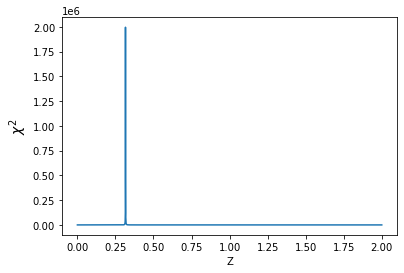

In [79]:
redshift_range = np.arange(0, 2.001, 0.001)

plt.plot(redshift_range, chi_squared_values)
#plt.xlim(0, 0.15)
#plt.ylim(100, 1050)
plt.ylabel(r'$\chi^2$', fontsize=14)
plt.xlabel('Z')

In [80]:
import astropy

In [81]:
spectrum = Spectrum(spec_combined.wave['brz'], flux_masked, 
                    ivar_masked, dense_array)

In [82]:
# Simulate a target with a single spectrum
target_id = 39628449278591796
target = Target(target_id, [spectrum])

# Simulate distributed targets with a single target
# Note: You might need to initialize MPI before using this code
#       or modify the DistTargetsCopy class accordingly if MPI is not used.

dtargets = DistTargetsCopy([target])

In [83]:
dwave = dtargets.wavegrids()
dtemplates = load_dist_templates(dwave)
templates = dict()
for dt in dtemplates:
    templates[dt.template.full_type] = dt.template

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Read and broadcast of 10 templates: 0.0 seconds
Rebinning templates: 11.7 seconds


In [84]:
zscan, zfit = zfind(dtargets, [dtemplates])

Computing redshifts
  Scanning redshifts for template GALAXY
    Progress:   0 %
    Progress:  10 %
    Finished in: 1.6 seconds
  Finding best fits for template GALAXY
    Finished in: 0.4 seconds


In [85]:
zfit

targetid,z,zerr,zwarn,chi2,zz [15],zzchi2 [15],coeff [10],npixels,spectype,subtype,ncoeff,znum,deltachi2
int64,float64,float64,int64,float64,float64,float64,float64,int64,str6,str20,int64,int64,float64
39628449278591796,0.09194247333985042,3.191298447543874e-05,0,84547.89089872409,0.09149834300269899 .. 0.09300734583308379,85342.67670558397 .. 86061.47529883328,4040.160384610666 .. -535.3114487831195,7774,GALAXY,,10,0,2243.9616245375946
39628449278591796,0.0782096631085217,1.995002548296887e-05,0,86791.85252326168,0.07726631655166294 .. 0.0787556435224055,87945.24804631286 .. 87105.32010474466,4668.292233792296 .. -472.7702468692759,7774,GALAXY,,10,1,501.56866425834596
39628449278591796,0.4376000087681612,2.7450663393468515e-05,4,87293.42118752003,0.4368885389940409 .. 0.4388750457864603,88183.10981807165 .. 89459.19335953727,2957.197291472779 .. 391.9573301136799,7774,GALAXY,,10,2,0.0


In [86]:
tid = target_id
t_qso = templates['GALAXY']

## several minima are stored in the zfit table
minumum_number = 0

## select the target id and minumum number
w = (zfit['targetid']==tid) & (zfit['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z']

## compute the best fit:
fit = t_qso.eval(coeff,spec_combined.wave['brz'],zbest)

## remultiply by (1+z)
fit *= (1+zbest)

Text(0, 0.5, 'Flux')

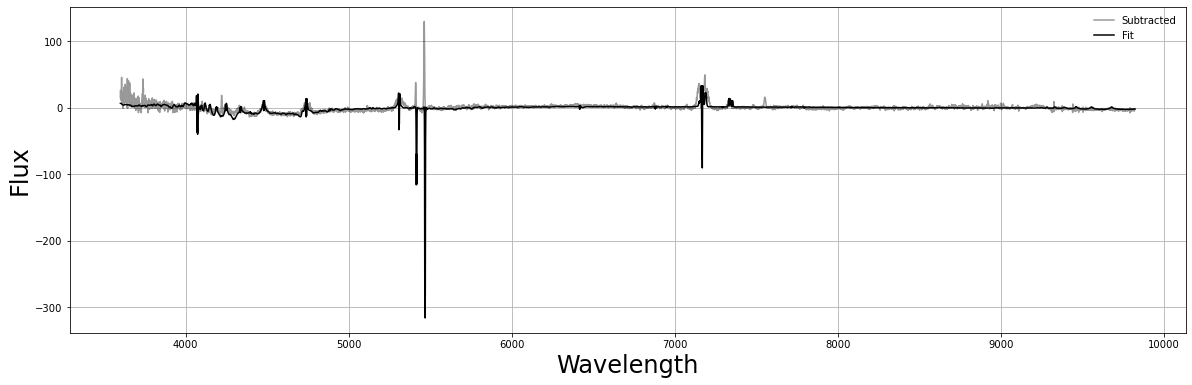

In [87]:
plt.figure(figsize = (20, 6))
#wave=spec_combined.wave['brz']
#flux = spec_combined.flux['brz'][0]
plt.plot(wave,y, 'k-', label = 'Subtracted', alpha = .4)
plt.plot(wave,fit, 'k-', label = 'Fit')

plt.legend(loc = 0, frameon = False)

plt.grid()
plt.xlabel("Wavelength",fontsize=24)
plt.ylabel("Flux",fontsize=24)

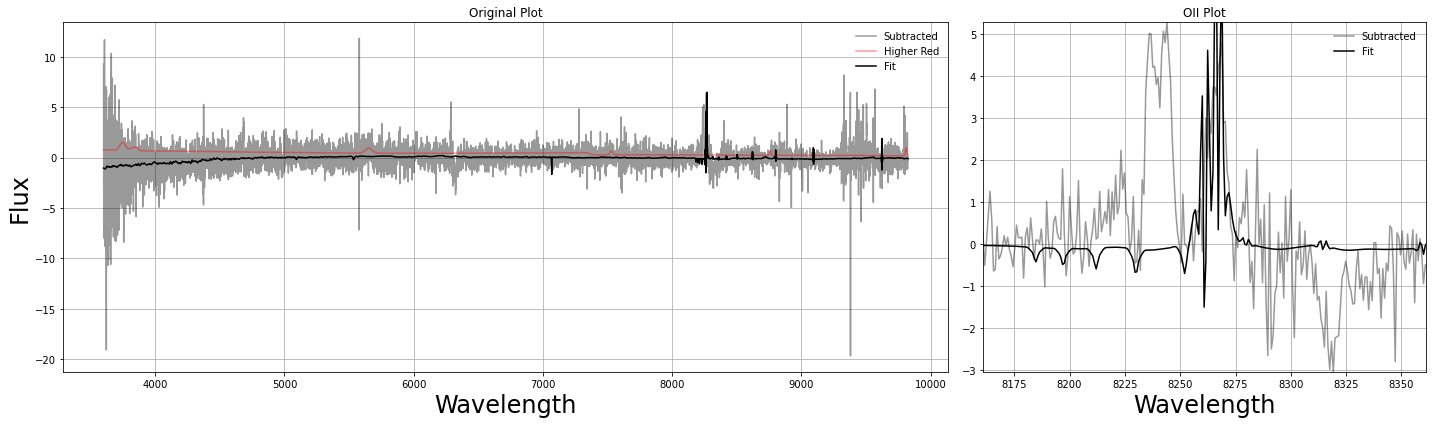

In [215]:
import matplotlib.gridspec as gridspec

# Define the x-range for the zoomed-in section
x_min = 3727 * (1 + zbest) - 100
x_max = 3727 * (1 + zbest) + 100
x_indices = np.where((wave >= x_min) & (wave <= x_max))
max_y_within_x_range = np.max(y[x_indices])
min_y_within_x_range = np.min(y[x_indices])

# Create a figure with two sections using gridspec
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Plot the original data on the left section
ax0 = plt.subplot(gs[0])
ax0.plot(wave, y, 'k-', label='Subtracted', alpha=0.4)
ax0.plot(wave, 5*flux, 'r-', label='Higher Red', alpha=0.4)
ax0.plot(wave, fit, 'k-', label='Fit')
ax0.set_xlabel("Wavelength", fontsize=24)
ax0.set_ylabel("Flux", fontsize=24)
ax0.grid(True)
ax0.legend(loc=0, frameon=False)
ax0.set_title('Original Plot')

# Plot the zoomed-in data on the right section
ax1 = plt.subplot(gs[1])
ax1.plot(wave, y, 'k-', label='Subtracted', alpha=0.4)
ax1.plot(wave, fit, 'k-', label='Fit')
ax1.set_xlabel("Wavelength", fontsize=24)
ax1.grid(True)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(min_y_within_x_range, max_y_within_x_range)
ax1.legend(loc=0, frameon=False)
ax1.set_title('OII Plot')

plt.tight_layout()
plt.show()

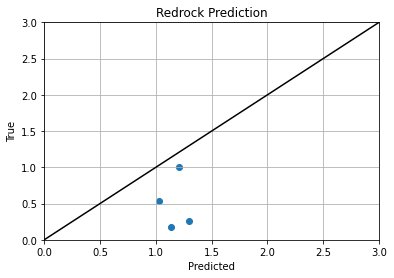

In [225]:
x = range(-10, 11)
x_new = [1.3, 1.03, 1.14, 1.21]
# Calculate y = x
y = [i for i in x]
y_new = [.26, .53, .17, 1.01]
# Plot the graph
plt.plot(x, y, 'k-')
plt.scatter(x_new, y_new)
plt.ylim(0, 3)
plt.xlim(0, 3)
# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Add a title to the plot
plt.title('Redrock Prediction')

# Display the plot
plt.grid(True)
plt.show()